# Classifying Dog Breeds with a CNN and Transfer Learning
### Ever wondered what type of a breed a dog is?
Let's use the power of CNN's and especially transfer learning to found out!

### Download an extract the dataset
Lets download the dataset and extract the zip file. We will also see a few examples, its always good to see the data you are working with first. The data is from udacity's classifying project.

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

In [ ]:
!unzip dogImages.zip

Image Shape:  (333, 500, 3)


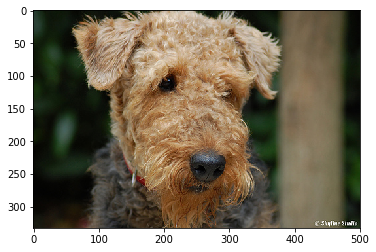

Image Shape:  (362, 400, 3)


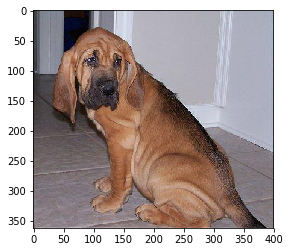

Image Shape:  (453, 500, 3)


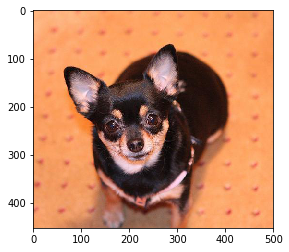

In [10]:
import matplotlib.image as mpimg                
import matplotlib.pyplot as plt                        
%matplotlib inline

def show_img(path):
    img = mpimg.imread(path)
    print("Image Shape: ", img.shape)
    plt.imshow(img)
    plt.show()

show_img("dogImages/train/003.Airedale_terrier/Airedale_terrier_00164.jpg")
show_img("dogImages/train/027.Bloodhound/Bloodhound_01904.jpg")
show_img("dogImages/train/048.Chihuahua/Chihuahua_03439.jpg")

### Includes

In [13]:
#for one-hot encoding labels
from keras.utils import np_utils
#for loading in file paths and labels
from sklearn.datasets import load_files  
import numpy as np
from glob import glob

### Load in pretrained InceptionV3 network and define functions to load images
For this project, we will use a pretrained model called InceptionV3, trained on imagenet dataset. Imagenet is a huge collection of small images with over 1000 different classes to predict. This gives the advantage of using a model that already has some learned knowledge, then fine tuning so it learns with our dataset. Check out the paper on InceptionV3 at the end of this notebook.

Since we are using pretrained weights from imagenet, it is a good idea to use the same input size that it was trained on, which is 299x299.

After the workshop, try using other pretrained models that come with Keras. Check them out [here](https://keras.io/applications/). InceptionResNetV2 or VGG16/VGG19 might be good models to try next. Make sure to check what the default image sizes for the network are!

In [11]:
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.vgg19 import VGG19
from keras.preprocessing import image as image_processor                 
from tqdm import tqdm

# include_top=False means that we only load in the convolutional layers of the network, not the classifier layers
# replace this with a different model if you want to try another model
inception_model = InceptionV3(weights='imagenet', include_top=False)
img_size = (299, 299)# for inceptionv3

def load_image_from_path(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image_processor.load_img(img_path, target_size=img_size)
    # convert PIL.Image.Image type to 3D tensor with shape (299, 299, 3)
    x = image_processor.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 299, 299, 3) and return 4D tensor
    # this extra dimension represents the number of images in this array, which in this case is just 1 
    return np.expand_dims(x, axis=0)

def load_directory(img_paths):
    images = [load_image_from_path(img_path) for img_path in tqdm(img_paths)]
    # loads in all images in img_path, then concates them along axis 0
    return np.vstack(images)


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


### Import dog images and labels

In [3]:
# needed because of truncated image error when loading train images:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_dataset(path):
    # from sklearn: returns filenames with a label 0-133 for each class
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_images = load_directory(dog_files)
    # one-hot encode labels
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_images, dog_targets

train_images, train_targets = load_dataset('dogImages/train')
valid_images, valid_targets = load_dataset('dogImages/valid')
test_images, test_targets = load_dataset('dogImages/test')

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

print("Train images shape: {}".format(train_images.shape))

100%|██████████| 836/836 [00:04<00:00, 187.87it/s]


Train images shape: (6680, 299, 299, 3)


### Model:
GlobalAveragePooling reduces dimension size such that the Dense layer can take it.

We use something you may of not seen before, and that is Keras' functional model API. This provides a bit more flexibility when building models than Sequential does. Build the last part of the model like you have seen before with Sequential. Add the last few Conv2D layers, MaxPool, and a final GlobalAverage pool before creating Dense layers for the classification. The last layer is given, for use with the model API.

Same padding pads with zeros around the image when the filter goes past the image.

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential, Model

output_model = Sequential()

### BEGIN SOLUTION ###
output_model.add(Conv2D(256, 2, strides=2, padding='same', activation='relu'))
output_model.add(Conv2D(512, 2, strides=2, padding='same', activation='relu'))
output_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
output_model.add(Conv2D(512, 2, strides=2, padding='same', activation='relu'))
output_model.add(GlobalAveragePooling2D())

output_model.add(Dense(3072, activation='relu'))
output_model.add(Dropout(0.5))
output_model.add(Dense(512, activation='relu'))
output_model.add(Dropout(0.3))
### END SOLUTION ###
out = inception_model.output
out = output_model(out)
out = Dense(133, activation='softmax')(out)

inception_model = Model(inputs=inception_model.input, outputs=out)
output_model.summary()
# inception_model.summary()#uncomment to see inception_model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, None, None, 256)   2097408   
_________________________________________________________________
conv2d_96 (Conv2D)           (None, None, None, 512)   524800    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, None, None, 512)   0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, None, None, 512)   1049088   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              1575936   
___________________________

### Model compiliation:

In [5]:
from keras import optimizers as opt 
inception_model.compile(loss='categorical_crossentropy', optimizer=opt.RMSprop(lr=0.0001), metrics=['accuracy'])

### Training:
Use a small batch size if you get an out of memory error.

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 300
batch_size = 4


checkpointer = ModelCheckpoint(filepath='weights.best.transfer.inception.test.hdf5', verbose=1, save_best_only=True)
early_stop = EarlyStopping(patience=10, verbose=1)
                           
inception_model.fit(train_images, train_targets, validation_data=(valid_images, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, early_stop], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6680 samples, validate on 835 samples
Epoch 1/300
6680/6680 [==============================] - 196s 29ms/step - loss: 4.3755 - acc: 0.0645 - val_loss: 3.0682 - val_acc: 0.2263

Epoch 00001: val_loss improved from inf to 3.06820, saving model to weights.best.transfer.inception.test.hdf5
Epoch 2/300
6680/6680 [==============================] - 185s 28ms/step - loss: 2.6603 - acc: 0.2991 - val_loss: 1.6489 - val_acc: 0.5545

Epoch 00002: val_loss improved from 3.06820 to 1.64894, saving model to weights.best.transfer.inception.test.hdf5
Epoch 3/300
6680/6680 [==============================] - 185s 28ms/step - loss: 1.6260 - acc: 0.5266 - val_loss: 1.2699 - val_acc: 0.6479

Epoch 00003: val_loss improved from 1.64894 to 1.26993, saving model to weights.best.transfer.inception.test.hdf5
Epoch 4/300
6680/6680 [==============================] - 185s 28ms/step - loss: 1.1562 - acc: 0.6476 - val_loss: 1.3111 - val_acc: 0.6683

Epoch 00004

### Load best validation loss weights:


In [ ]:
#download weights for the model I trained if using my netwhttps://drive.google.com/uc?export=download&confirm=RDkU&id=1EexGOGyFaqVWshRUaZdXe5y3RFWXQlzrork:
!./gdown.pl https://drive.google.com/file/d/1EexGOGyFaqVWshRUaZdXe5y3RFWXQlzr/view weights.best.transfer.inception.test.hdf5

In [16]:
inception_model.load_weights('weights.best.transfer.inception.test.hdf5')

### Test model accuracy:

In [8]:
metrics = inception_model.evaluate(test_images, test_targets)

print('Test loss: {0:.4f}, Test accuracy: {1:.2f}%'.format(metrics[0], metrics[1]*100))

836/836 [==============================] - 7s 8ms/step
Test loss: 1.3371, Test accuracy: 64.59%


### Lets see some dogs!

In [17]:
def classify(image_path):
    display_img = mpimg.imread(image_path)
    print("Hello!")
    plt.imshow(display_img)
    plt.show()
    input_img = load_image_from_path(image_path)
    pred_class = dog_names[np.argmax(inception_model.predict(input_img))]
    print("You are a {} dog!! {}/10".format(pred_class, np.random.randint(low=10, high=15, size=None)))

Hello!


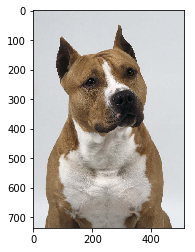

You are a American_staffordshire_terrier dog!! 11/10


In [18]:
classify("dogImages/test/008.American_staffordshire_terrier/American_staffordshire_terrier_00538.jpg")

## References